# Отток клиентов из "Бета-Банк"

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

-----
**Описание данных:** Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Признаки:**
* **RowNumber** — индекс строки в данных
* **CustomerId** — уникальный идентификатор клиента
* **Surname** — фамилия
* **CreditScore** — кредитный рейтинг
* **Geography** — страна проживания
* **Gender** — пол
* **Age** — возраст
* **Tenure** — сколько лет человек является клиентом банка
* **Balance** — баланс на счёте
* **NumOfProducts** — количество продуктов банка, используемых клиентом
* **HasCrCard** — наличие кредитной карты
* **IsActiveMember** — активность клиента
* **EstimatedSalary** — предполагаемая зарплата

**Целевой признак:**
* **Exited** — факт ухода клиента

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

-----
**Задача:** Построить модель с предельно большим значением *F1*-меры. Нужно довести метрику до 0.59 и проверить *F1*-меру на тестовой выборке самостоятельно.

Дополнительно необходимо измерить *AUC-ROC* и сравнить со *F1*-мерой.

-----
**Цель:** Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Подготовка данных

In [2]:
#Подгружаем необходимые библиотеки для работы с данными и машинного обучения
import warnings
import timeit
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_absolute_error, 
                             f1_score, 
                             roc_curve, 
                             roc_auc_score, 
                             confusion_matrix)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Подгружаем дополнительные полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
#Уберем warnings, чтобы не мешали
warnings.filterwarnings("ignore")

In [4]:
#Загружаем и проверяем файл с данными
try:
    data= pd.read_csv('C:/Users/kiril/OneDrive/Рабочий стол/Практикум/Проекты/Спринт 7. Обучение с учителем/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')
    
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


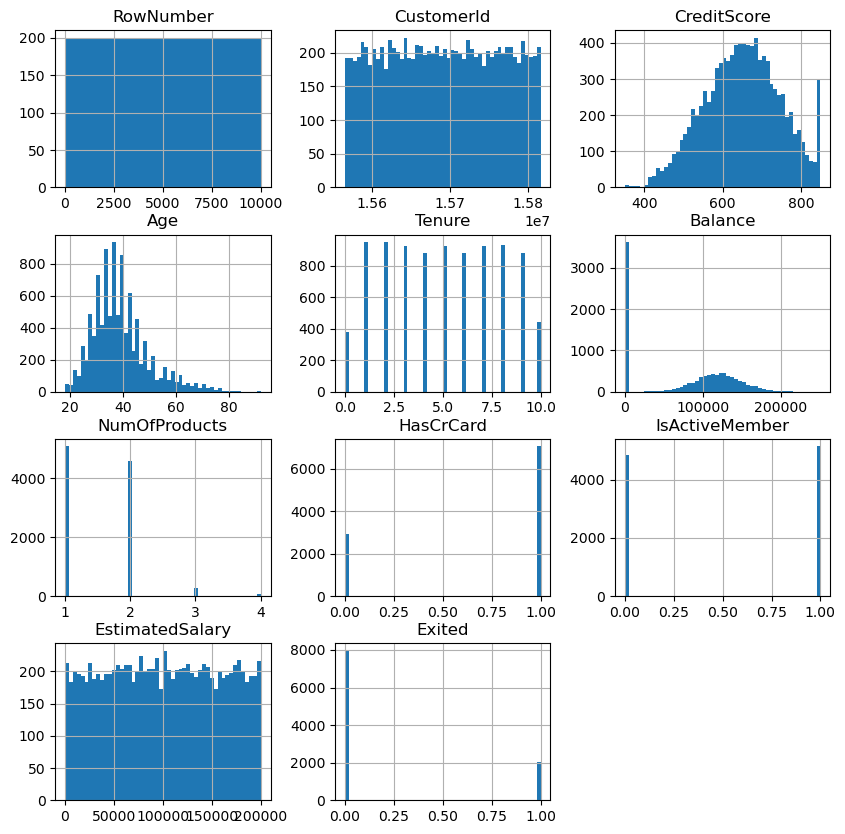

In [5]:
#Выведем информацию о датафрейме и гистограммы
data.info()
data.hist(figsize=(10,10), bins=50);

In [6]:
#Выведем описание всех столбцов в данных
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


In [7]:
#Проверим, что за пропущенные значения в столбце Tenure
data.loc[data['Tenure'].isna() == True].head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Видно, что какой-либо взаимосвязи пропущенных значений с каким-либо признаком нету, поэтому лучше оставить данные значения пустыми, а для создания модели их лучше не учитывать

In [8]:
#Уберем строки с пропущенными значениями
data = data.loc[data['Tenure'].isna() == False]

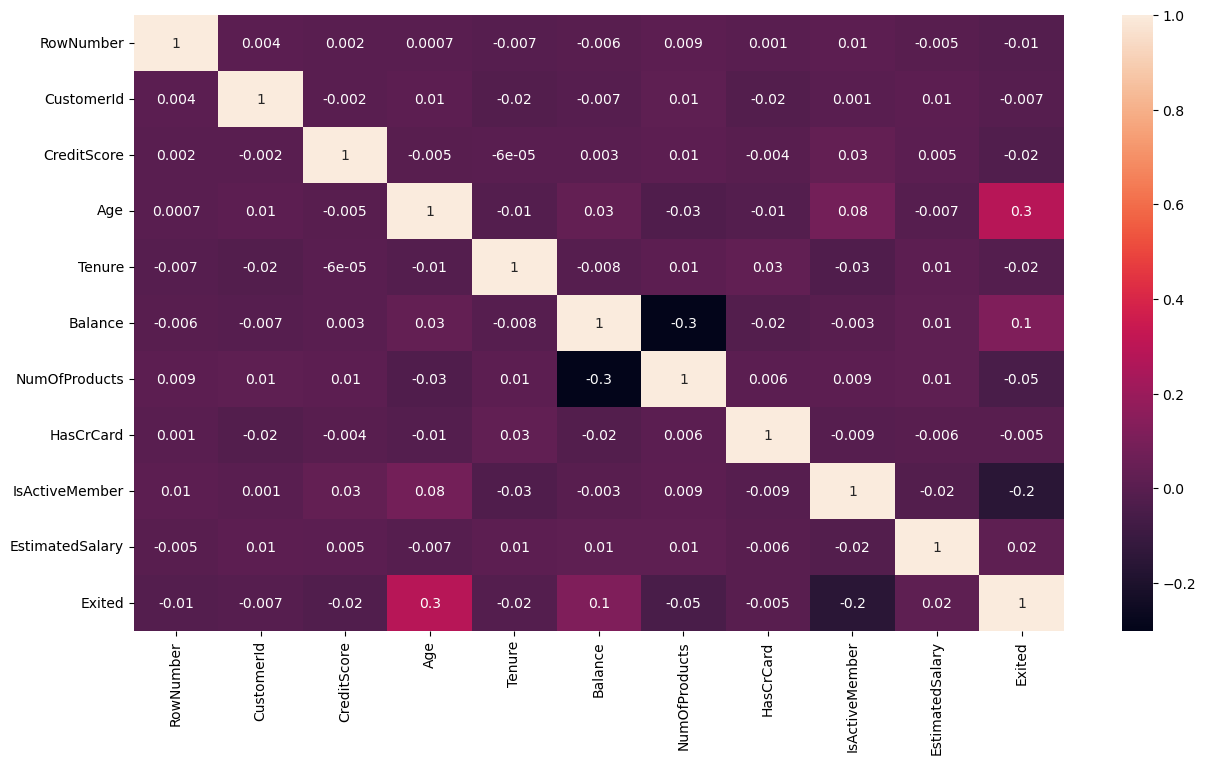

In [9]:
#Выведем тепловую карту, чтобы понять, какие параметры наибольшим образом коррелируют между собой
plt.figure(figsize = (15,8))
sns.heatmap(data.corr(), annot=True, fmt='.1g');

In [10]:
#Выведем теперь параметр VIF для поиска коллинеарных признаков 
vif_data = pd.DataFrame()
vif_data['feature'] = data.iloc[:,[3,6,7,8,9,10,11,12]].columns
vif_data['VIF'] = [variance_inflation_factor(data.iloc[:,[3,6,7,8,9,10,11,12]].values, i) for i in range(len(data.iloc[:,[3,6,7,8,9,10,11,12]].columns))]
vif_data

,feature,VIF
0,CreditScore,20.535772
1,Age,12.161423
2,Tenure,3.844150
3,Balance,2.625237
4,NumOfProducts,7.697058
5,HasCrCard,3.284080
6,IsActiveMember,2.074526
7,EstimatedSalary,3.889577


Предлагаю убрать столбцы CustomerID и Surname, т.к. они очень индивидуальны и смысла включать их в обучение и прогноз нет смысла.

In [11]:
#Убираем столбцы CustomerID и Surname
data = data.drop(['RowNumber','CustomerId', 'Surname'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


Разделим данные на три выборки: обучающую, валидационную и тестовую, - в соотношении 60:20:20%

In [12]:
#Разделим данные на выборки: обучающую, валидационную и тестовую 
features = data.drop('Exited', axis=1)
target = data['Exited']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(5454, 10)
(5454,)
(1819, 10)
(1819,)
(1818, 10)
(1818,)


Далее преобразуем категориальные признаки в численные с помощью прямого кодирования OHE (а именно Пол и Страну).

In [13]:
#Применим OHE к данным
columns_ohe = ['Geography', 'Gender']

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[columns_ohe])
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[columns_ohe])
features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid[columns_ohe])
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[columns_ohe])

features_train = features_train.drop(columns_ohe, axis=1)
features_valid = features_valid.drop(columns_ohe, axis=1)
features_test = features_test.drop(columns_ohe, axis=1)

features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9723,526,32,7.0,125540.05,1,0,0,86786.41,0.0,0.0,1.0
1224,500,47,8.0,128486.11,1,1,0,179227.12,0.0,1.0,0.0
8377,802,40,4.0,0.00,2,1,1,81908.09,0.0,1.0,1.0
8014,731,39,2.0,126816.18,1,1,1,74850.93,0.0,1.0,0.0
2491,612,26,4.0,0.00,2,1,1,179780.74,0.0,1.0,0.0


Теперь приведем численные признаки к одному масштабу с помощью метода StandatScaler()

In [14]:
#Используем метод StandartScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Выводы:**

1) Данные выглядят без вылетов, пропущенные значения есть только в столбце Tenure, но заполнять их не стоит. Строки с пропущенными значениями удалены для более точного обучения и прогноза;\
2) Максимальный кредитный рейтинг 850, наиболее частый рейтинг клиентов примерно равен 650-700; \
3) Большинство клиентов младше 40 лет; \
4) Очень большое количество клиентов имеет нулевой баланс на счете; \
5) Большинство клиентов пользуются одним или двумя продуктами; \
6) Большинство клиентов имеют кредитные карты; \
7) Чуть более половины клиентов являются активными; \
8) Зарплата клиентов сильно разная; \
9) Между собой параметры практически не взаимосвязаны. Параметр VIF больше 10 (но несильно) для двух признаков: кредитный рейтинг и возраст; \
10) Категориальные данные переведены в количественные методом OHE; \
11) Признаки разделены на три выборки: обучающую, валидационную и тестовую, - в соотношении 60:20:20%; \
12) Численные признаки масштабированы методом StandartScaler()

## Исследование задачи

Теперь посчитаем количество значений каждого класса, чтобы понять, насколько не сбалансированы данные

In [15]:
#Рассчитываем количество значений каждого класса
data.groupby('Exited')['Exited'].count()

Exited
0    7237
1    1854
Name: Exited, dtype: int64

Мы видим, что выборка несбалансирована, значений для класса 1 значительно меньше, чем для 0. Попробуем рискнуть и обучить модели для несбалансированных данных

Далее будут 2 функции, которые работают вместе и позвляют сделать общую сводную таблицу для всех методов. Идея такая: 
* берем сначала средний диапазон, например [10,100,10];
* если лучшее решение будет с гиперпараметром 100 (макс. зн-е), то соответственно произойдет увеличение диапазона до [100,1000,100]; 
* если лучшее решение будет с гиперпараметром 10 (мин. зн-е), то соответственно произойдет уменьшение диапазона до [1,10,1];

Цикл каждого из данных направлений заканчивается, пока лучший гиперпараметр не будет находиться в промежутке между мин. и макс. значениями (это очень быстро).
    
* далее допустим, что лучшее решение получилось с гиперпараметром 900 при диапазоне [100,1000,100]. Тогда цикл сокращает диапазон до [800,1000,10]. Далее гипрепараметр получился, допустим, 860. Тогда диапазон сокращается до [850,870,1]. А уже из этого диапазона выбирается лучшее значение;
* Итог: получается максимальная точность при нахождении лучшего решения для каждого способа (проверено по сравнению с ручным поиском нужного диапазона  и на графиках) при полной автоматизации подбора диапазона, при этом поиск не занимает большого количества времени из-за постепенного отсечения значений диапазона.

Также было замечено, что ввод максимальной глубины деревьев в методе Рандомный лес не всегда улучшает F1-меру. В любом случае в функции предусмотрен переход на поиск лучшего значения для max_depth.

Также функции предусматривают работу с дисбалансом классов (оставить его или нет), cчитают вероятности классов, а также подбирают наилучший порог классификации (если выбрать True)

In [16]:
#Создадим функцию, которая будет находить лучший вариант в зависимости от выбора модели
#Максимальная глубина дерева для линейной регресси здесь подбирается с шагом 2 от 1 до 50

def model_choice(kind_model, 
                 features_train,
                 target_train,
                 features_valid,
                 target_valid,
                 k, 
                 n, 
                 d,
                 weight):
#Начинаем отсчет времени
    start_time = timeit.default_timer()
#Ищем лучший вариант
    best_model = None
    best_f1 = 0
    best_hyperparam = 0
    best_depth = None
    for i in range(k,n,d):
        if kind_model == DecisionTreeClassifier:
            model=kind_model(random_state=12345, max_depth=i, class_weight=weight)          
        elif kind_model == RandomForestClassifier:
            model=kind_model(random_state=12345, n_estimators=i, class_weight=weight)
        elif kind_model == LogisticRegression:         
            model=kind_model(random_state=12345, solver='liblinear', max_iter=i, class_weight=weight)
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions)
        if f1 > best_f1:
            best_model = model
            best_f1 = f1
            best_hyperparam = i
        if (kind_model == RandomForestClassifier) and (i == n-1) and (d==1):
            for j in range(1,50,2):
                model=kind_model(random_state=12345, n_estimators=best_hyperparam, max_depth=j, class_weight=weight)
                model.fit(features_train,target_train)               
                predictions = model.predict(features_valid)
                f1 = f1_score(target_valid, predictions)
                if f1 > best_f1:
                    best_model = model
                    best_f1 = f1
                    best_depth = j
        
#Заканчиваем подсчет времени
    end_time = timeit.default_timer() - start_time
    return best_model, best_f1, end_time, best_hyperparam, best_depth

In [17]:
#Теперь создадим функцию для создания сводной таблицы со всеми лучшими моделями 

def pivot(features_train,
          target_train,
          features_valid,
          target_valid,
          weight,
          threshold):                                                                  
    model_f1 = []
    model_time = []
    model_hyperparam = []
    model_threshold = []
    model_depth = []
    GOAT_model = None
    GOAT_f1 = 0
    for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
        k = 10
        n = 100
        d = 10
        best_model, best_f1, end_time, best_hyperparam, best_depth = model_choice(i,
                                                                      features_train,
                                                                      target_train,
                                                                      features_valid,
                                                                      target_valid,                                                                  
                                                                      k, 
                                                                      n, 
                                                                      d,
                                                                      weight)
        if best_hyperparam == n:
            while best_hyperparam == n:
                k = int(n)
                d = int(n)
                n = int(n*10)
                best_model, best_f1, end_time, best_hyperparam, best_depth = model_choice(i,
                                                                              features_train,
                                                                              target_train,
                                                                              features_valid,
                                                                              target_valid,                                                                  
                                                                              k, 
                                                                              n, 
                                                                              d,
                                                                              weight)
        if best_hyperparam == k:
            while (best_hyperparam == k) and (k > 1):
                n = int(k)
                d = int(k/10)
                k = int(k/10)
                best_model, best_f1, end_time, best_hyperparam, best_depth = model_choice(i,
                                                                              features_train,
                                                                              target_train,
                                                                              features_valid,
                                                                              target_valid,                                                                  
                                                                              k, 
                                                                              n, 
                                                                              d,
                                                                              weight)
        while d > 1:
            n = int(best_hyperparam + d)
            k = int(n - d)
            d = int(d/10)
            best_model, best_f1, end_time, best_hyperparam, best_depth = model_choice(i,
                                                                          features_train,
                                                                          target_train,
                                                                          features_valid,
                                                                          target_valid,                                                                  
                                                                          k, 
                                                                          n, 
                                                                          d,
                                                                          weight) 
        if threshold == True:
            for thres in np.arange(0, 0.5, 0.02):
                predicted_valid = best_model.predict(features_valid)
                probabilities_valid = best_model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1] 
                predicted_valid[probabilities_one_valid > thres] = 1
                f1_thres = f1_score(target_valid, predicted_valid)
                if f1_thres > best_f1:
                    best_f1 = f1_thres
                    best_threshold = thres
            model_threshold.append(best_threshold)
        model_f1.append(best_f1)
        model_time.append(end_time)
        model_hyperparam.append(best_hyperparam)
        model_depth.append(best_depth)        
        if GOAT_f1 < best_f1:
            GOAT_model = best_model
        GOAT_f1 = best_f1
    
    pivot_model = pd.DataFrame({'F1' : model_f1, 
                                'Время' : model_time, 
                                'Гиперпараметр' : model_hyperparam,
                                'Глубина деревьев' : model_depth}, 
                               index=['Дерево решений', 'Случайный лес', 'Регрессия'])
    
    if threshold == True:
        pivot_model['Порог'] = model_threshold
    
    print('Лучшая модель:', GOAT_model)
    return pivot_model.round(3)

#P.S. GOAT - величайший (Great of All Time)

In [18]:
#Применим полученную функцию
pivot(features_train,
      target_train,
      features_valid,
      target_valid,
      None,
      False)

Лучшая модель: RandomForestClassifier(max_depth=15, n_estimators=60, random_state=12345)


,F1,Время,Гиперпараметр,Глубина деревьев
Дерево решений,0.558,0.084,7,NaN
Случайный лес,0.566,10.465,60,15.0
Регрессия,0.355,0.066,3,NaN


**Выводы:**

Несмотря на существующий дисбаланс классов, получилась достаточно высокая F-мера (0.566) для валидационной выборки на модели RandomForest. Немного меньше у дерева решений и совсем низкие значения у регрессии. 

## Борьба с дисбалансом

Существует несколько методов борьбы с дисбалансом классов:
* взвешивание классов с помощью class_weight
* увеличение выборки
* уменьшение выборки
* изменение порога классификации

Применим каждый из них и выберем наиболее оптимальный

In [19]:
#Посмотрим, как повлияет взвешивание классов
pivot(features_train,
      target_train,
      features_valid,
      target_valid,
      'balanced',
      False)

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=81,
                       random_state=12345)


,F1,Время,Гиперпараметр,Глубина деревьев
Дерево решений,0.568,0.122,8,NaN
Случайный лес,0.605,14.531,81,11.0
Регрессия,0.509,0.067,3,NaN


Отлично, увеличили F-меру для всех трех моделей.

In [20]:
#Применим увеличение выборки, с учетом того, что класса 0 больше 1 в 3.9 раза
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#Построим сводную таблицу
pivot(features_upsampled,
      target_upsampled,
      features_valid,
      target_valid,
      None,
      False)

Лучшая модель: RandomForestClassifier(max_depth=21, n_estimators=80, random_state=12345)


,F1,Время,Гиперпараметр,Глубина деревьев
Дерево решений,0.571,0.120,8,NaN
Случайный лес,0.607,17.763,80,21.0
Регрессия,0.511,0.103,1,NaN


Отлично, сделали F1-меру еще лучше.

In [21]:
#Применим уменьшение выборки, с учетом того, что класса 0 больше 1 в 3.9 раза
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#Построим сводную таблицу
pivot(features_downsampled,
      target_downsampled,
      features_valid,
      target_valid,
      None, 
      False)

Лучшая модель: RandomForestClassifier(max_depth=19, n_estimators=72, random_state=12345)


,F1,Время,Гиперпараметр,Глубина деревьев
Дерево решений,0.558,0.052,4,NaN
Случайный лес,0.577,6.661,72,19.0
Регрессия,0.509,0.047,3,NaN


А вот уменьшение выборки наоборот сделало только хуже. Остановимся на варианте с увеличением выборки

In [22]:
#Теперь применим способ изменения порогового значения классификации
pivot(features_train,
      target_train,
      features_valid,
      target_valid,
      None, 
      True)

Лучшая модель: RandomForestClassifier(max_depth=15, n_estimators=60, random_state=12345)


,F1,Время,Гиперпараметр,Глубина деревьев,Порог
Дерево решений,0.574,0.097,7,NaN,0.32
Случайный лес,0.596,10.010,60,15.0,0.38
Регрессия,0.499,0.070,3,NaN,0.22


Изменение порогового значения значительно помогло поднять значение F1-меру.

Согласно полученным результатам лучшим способом борьбы с дисбалансом классов является увеличение выборки. \
Рассмотрим, как выглядит обучение каждой модели в зависимости от изменения гиперпараметра на графиках.

In [23]:
#Сделаем отдельную функцию для графиков
def model_graf(kind_model, 
               features_train,
               target_train,
               features_valid,
               target_valid,
               k, 
               n, 
               d,
               weight):
    all_f1_train = []
    all_f1_valid = []
    x = []
    for i in range(k,n,d):
        if kind_model == DecisionTreeClassifier:
            model=kind_model(random_state=12345, max_depth=i, class_weight=weight)
        elif kind_model == RandomForestClassifier:
            model=kind_model(random_state=12345, n_estimators=i, class_weight=weight)
        elif kind_model == LogisticRegression:         
            model=kind_model(random_state=12345, solver='liblinear', max_iter=i, class_weight=weight)
        model.fit(features_train,target_train)
        predictions_train = model.predict(features_train)
        predictions_valid = model.predict(features_valid)
        f1_train = f1_score(target_train,predictions_train) 
        f1_valid = f1_score(target_valid,predictions_valid) 
        all_f1_train.append(f1_train)
        all_f1_valid.append(f1_valid)
        x.append(i)
        if (kind_model == DecisionTreeClassifier) and (i==3):
            plt.figure(figsize=(35,15))
            plot_tree(model, 
                      feature_names=features_train.columns.values, 
                      class_names=['Неуход','Уход'],
                      filled=True,
                      fontsize = 15,
                      max_depth = 3     # Это чтобы прорисовывало 3 уровня, не глубже
                      )
    plt.figure(figsize=(12,5))
    plt.plot(x, all_f1_train, label='Тренировочная')
    plt.plot(x, all_f1_valid, label='Валидационная')
    plt.title(kind_model)
    plt.xticks(np.arange(k,n,d))
    plt.xlabel('Гиперпараметр')
    plt.ylabel('f1_score')
    plt.legend()
    return f1_train

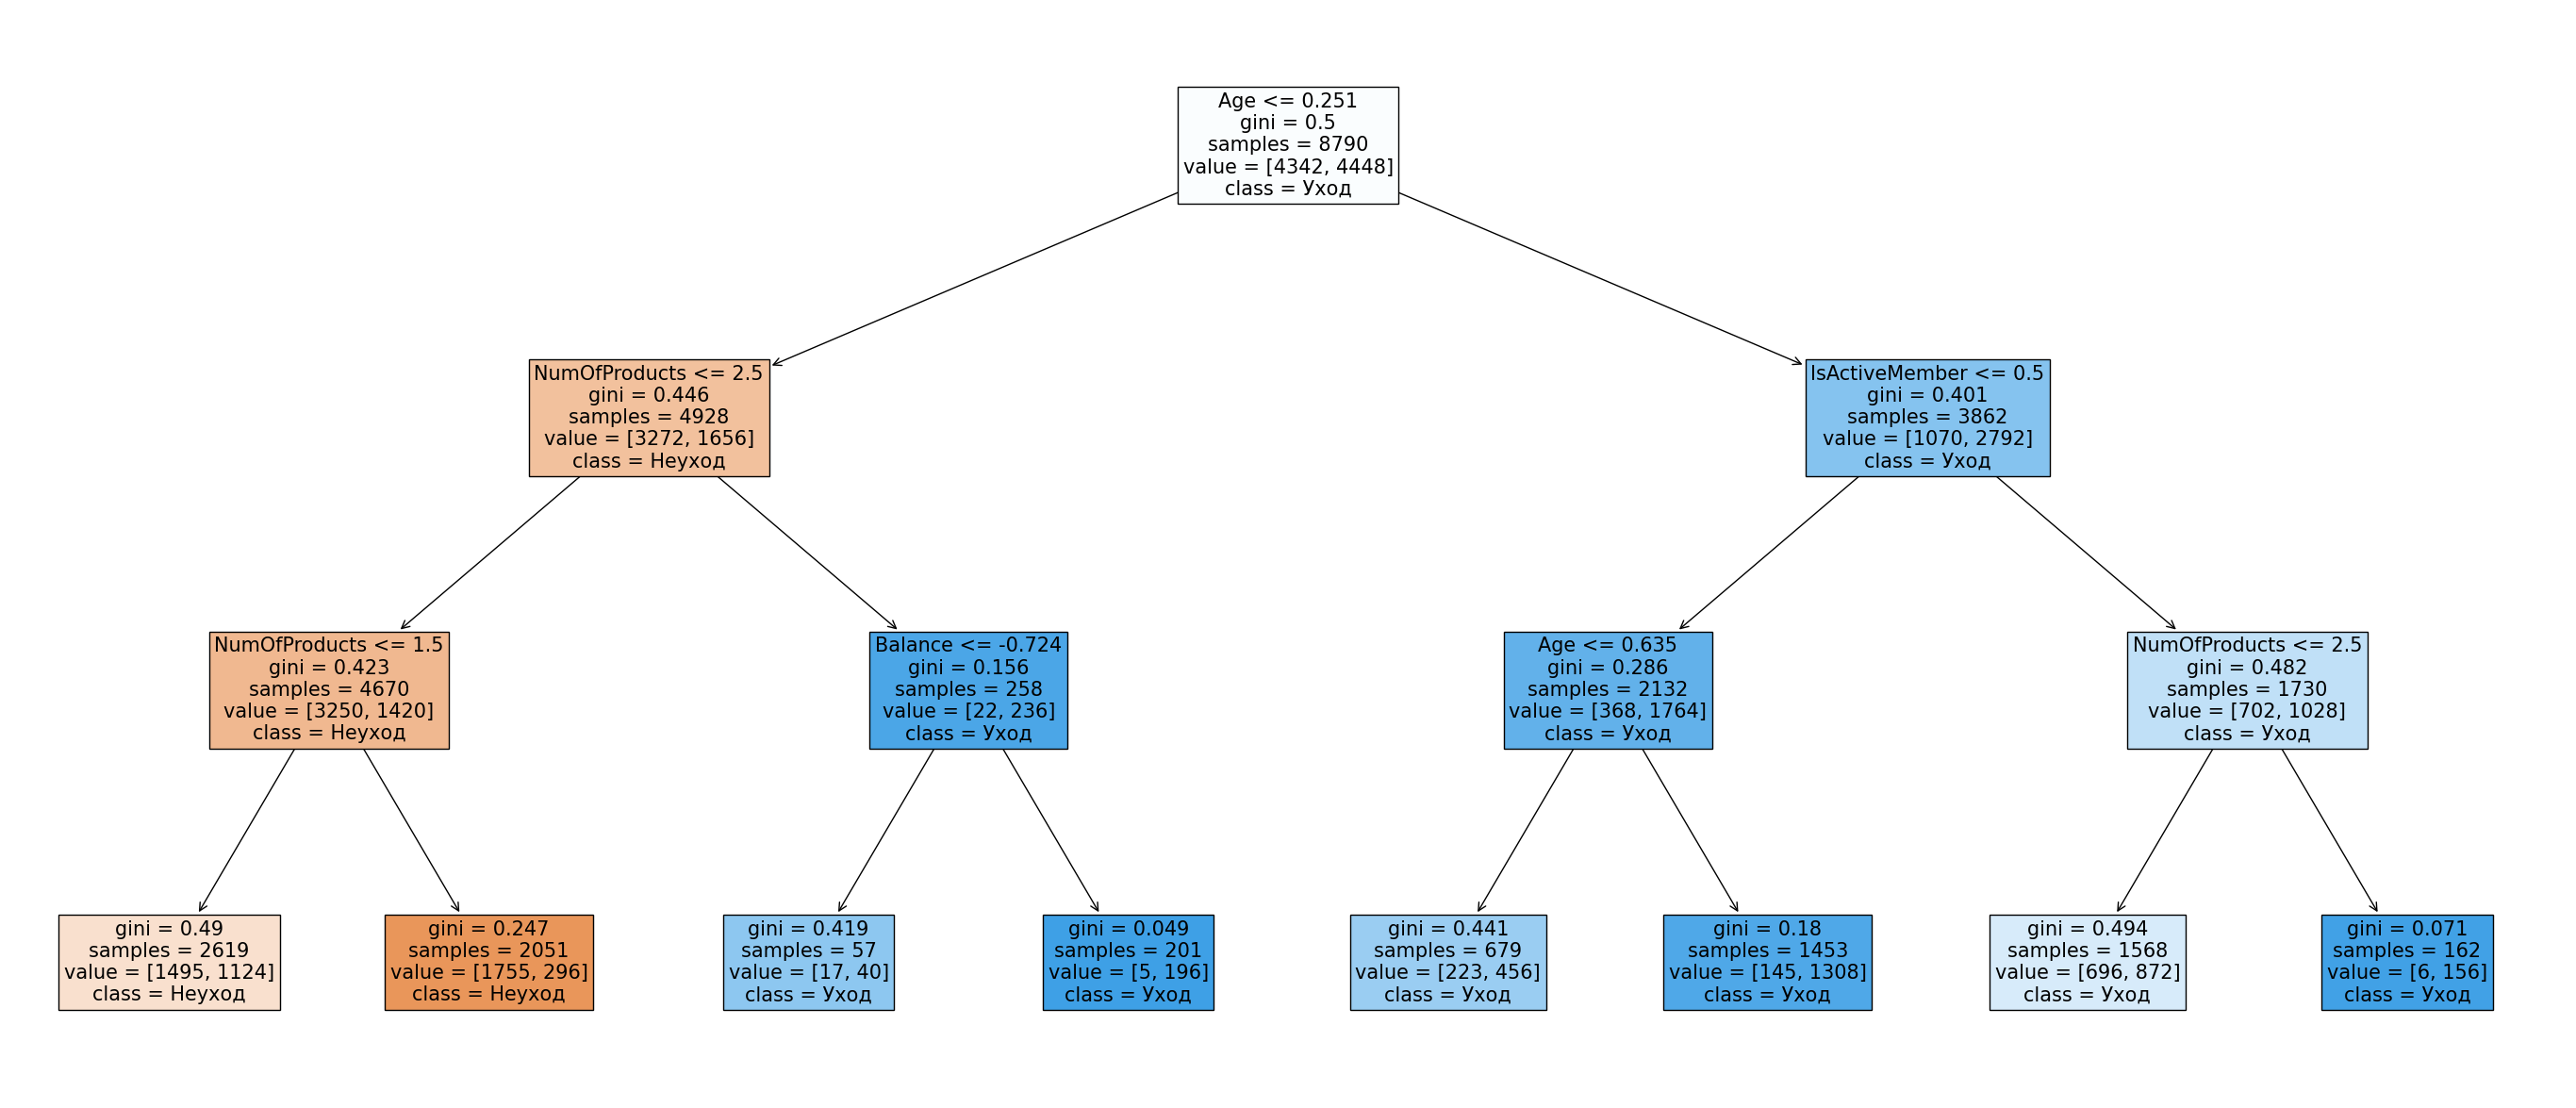

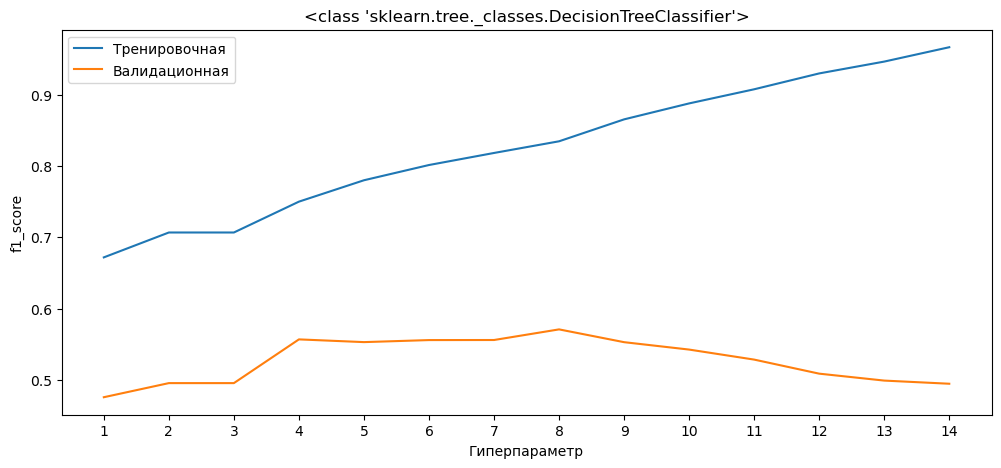

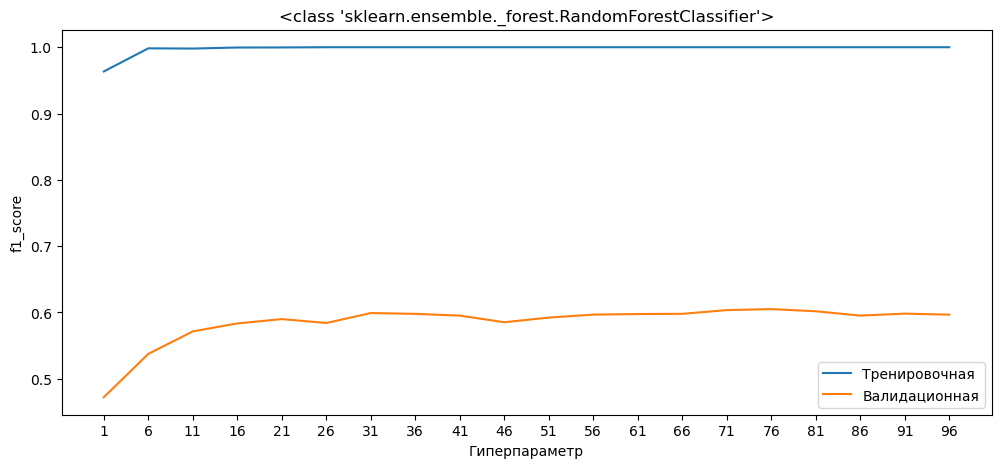

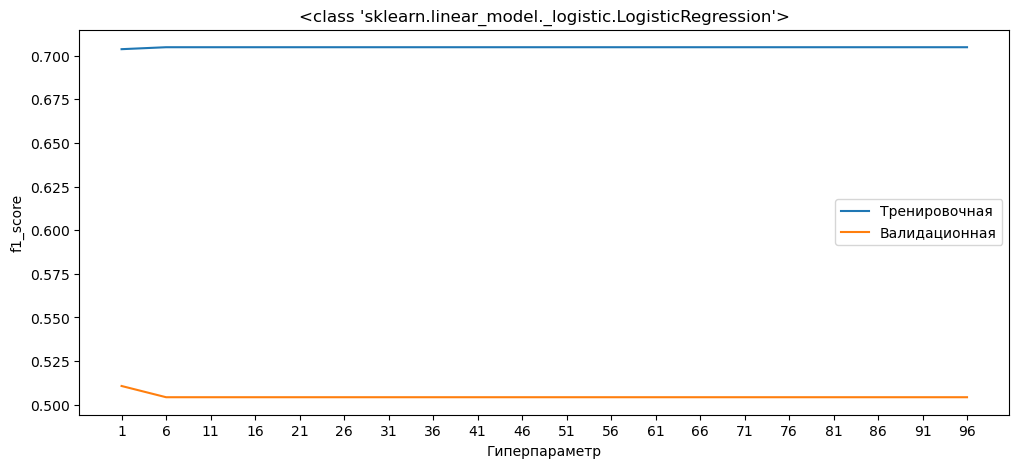

In [24]:
#Применим функцию и построим графики
for i in [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]:
    if i == DecisionTreeClassifier:
        k = 1
        n = 15
        d = 1
    else:
        k = 1
        n = 100
        d = 5
    model_graf(i, 
               features_upsampled,
               target_upsampled,
               features_valid,
               target_valid, 
               k, 
               n, 
               d,
               None)

**Выводы:**

* Лучшим способом борьбы с дисбалансом классов оказалось увеличение выборки (очень близко к нему взвешивание классов);
* F-мера увеличилась до 0.607 по лучшей модели, а именно **RandomForestClassifier(max_depth=21, n_estimators=80, random_state=12345)**; 
* Случайный лес зачастую оказывается одним из лучших вариантов, потому что он не склонен к переобучению, в отличие от Дерева решений (видно на графиках). 

## Тестирование модели

Лучшая модель выбрана, дисбаланс классов в тренировочных моделях устранен, теперь проверим результаты на тестовой модели.

In [25]:
model = RandomForestClassifier(max_depth=21, n_estimators=80, random_state=12345)
model.fit(features_upsampled, target_upsampled)

start_time = timeit.default_timer()
test_predictions = model.predict(features_test)
f1_test = f1_score(target_test, test_predictions)
end_time = timeit.default_timer() - start_time

print(f'Точность тестовой выборки: {round(f1_test, 3)}')
print(f'Время расчета: {round(end_time, 3)}')

Точность тестовой выборки: 0.632
Время расчета: 0.025


In [26]:
#Построим матрицу путаницы
confusion_matrix(target_test, test_predictions)

array([[1348,   99],
       [ 154,  217]], dtype=int64)

In [27]:
#Создадим датафрейм с точностью нахождения классов
confusion = pd.DataFrame({'1_pred' : [1277,170], 
                            '0_pred' : [121,250]}, 
                           index=['1_actual', '0_actual'])

confusion['sum_mean'] = confusion['1_pred'] + confusion['0_pred']
confusion['1_pred'] = confusion['1_pred'] / confusion['sum_mean']
confusion['0_pred'] = confusion['0_pred'] / confusion['sum_mean']
confusion.round(3)

,1_pred,0_pred,sum_mean
1_actual,0.913,0.087,1398
0_actual,0.405,0.595,420


По матрице путанницы видно, что факт ухода клиента прогнозируется отлично. Но класс 0 предсказывается не совсем точно.

Теперь построим ROC кривую и посчитатем площадь под этой кривой AUC_ROC, чтобы проверить, насколько хорошо модель разделяет два класса между сообой.

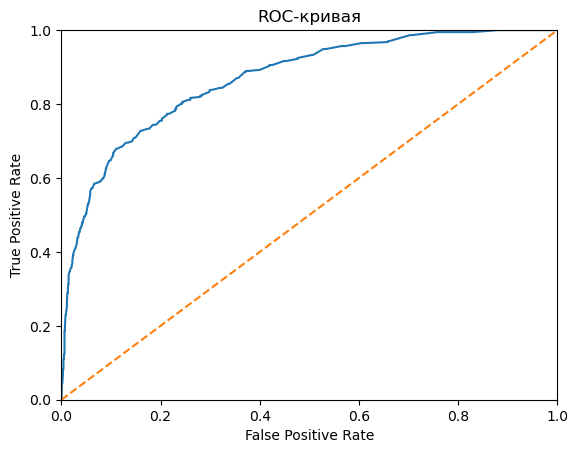

AUC_ROC: 0.868


In [28]:
#Расчет ROC-кривой и AUC_ROC
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:,1])
plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC_ROC:', auc_roc.round(3))

**Выводы:**

F1-мера для тестовой выборки (0.632) значительно выше порогового значения 0.59. AUC_ROC для выбранной модели получился значительно выше, чем у случайной модели, что говорит о неплохой точночти в предсказании класса

## Общие выводы

**1. Подготовка данных**:
* Данные выглядят без вылетов, пропущенные значения есть только в столбце Tenure, но заполнять их не стоит. Строки с пропущенными значениями удалены для более точного обучения и прогноза;
* Максимальный кредитный рейтинг 850, наиболее частый рейтинг клиентов примерно равен 650-700; 
* Большинство клиентов младше 40 лет; 
* Очень большое количество клиентов имеет нулевой баланс на счете; 
* Большинство клиентов пользуются одним или двумя продуктами; 
* Большинство клиентов имеют кредитные карты; 
* Чуть более половины клиентов являются активными; 
* Зарплата клиентов сильно разная; 
* Между собой параметры практически не взаимосвязаны. Параметр VIF больше 10 (не несильно) для двух признаков: кредитный рейтинг и возраст; 
* Категориальные данные переведены в количественные методом OHE; 
* Признаки разделены на три выборки: обучающую, валидационную и тестовую, - в соотношении 60:20:20%; 
* Численные признаки масштабированы методом StandartScaler()
------

**2. Исследование задачи**:

Несмотря на существующий дисбаланс классов, получилась достаточно высокая F-мера (0.566) для валидационной выборки на модели RandomForest. Немного меньше у дерева решений и совсем низкие значения у регрессии.  

------

**3. Борьба с дисбалансом**:

* Лучшим способом борьбы с дисбалансом классов оказалось увеличение выборки (очень близко к нему взвешивание классов);
* F-мера увеличилась до 0.607 по лучшей модели, а именно **RandomForestClassifier(max_depth=21, n_estimators=80, random_state=12345)**; 
* Случайный лес зачастую оказывается одним из лучших вариантов, потому что он не склонен к переобучению, в отличие от Дерева решений (видно на графиках). 

------

**4. Тестирование модели**:

* F1-мера для тестовой выборки (0.632) значительно выше порогового значения 0.59; 
* AUC_ROC для выбранной модели получился значительно выше, чем у случайной модели, что говорит о неплохой точночти в предсказании класса